# Library

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import dates as mpl_dates
import statsmodels.api as sm

from dateutil.rrule import *
from datetime import date


plt.style.use('seaborn')

# Data

In [2]:
data = pd.read_csv('Data\interview_data.csv')
data['Date']=pd.to_datetime(data['Date'])
data = data.set_index(['Date'])

data.head(3)

,Area
Date,
1999-07-12,B
1999-12-17,E
1999-12-24,D


In [3]:
data.index

DatetimeIndex(['1999-07-12', '1999-12-17', '1999-12-24', '1999-12-27',
               '1999-12-27', '1999-12-28', '2000-01-02', '2000-01-02',
               '2000-01-06', '2000-01-07',
               ...
               '2012-11-01', '2012-11-01', '2012-11-02', '2012-12-01',
               '2012-12-01', '2012-12-01', '2012-12-01', '2012-12-01',
               '2012-12-01', '2012-12-07'],
              dtype='datetime64[ns]', name='Date', length=30000, freq=None)

In [4]:
print('Min :',min(data.index)) 
print('Max :',max(data.index))
min_date = min(data.index)
max_data = max(data.index)


Min : 1999-07-12 00:00:00
Max : 2012-12-07 00:00:00


In [5]:
# creating a daily date range that covers all the data, this would ensure that all the dates are recorded as per the occurance on date.
# ie, we will then be able to just fit a series/forecasting method on it while ignoring the date.

days = [dt.date().isoformat() for dt in rrule(DAILY, dtstart=date(1999, 7, 1), until=max_data)]
tmp_date = pd.DataFrame(list(days)).rename({0:'Date'},axis=1)
tmp_date['Date'] = pd.to_datetime(tmp_date['Date'])

# groupby data
tmp_dt = data.groupby([pd.Grouper(freq='D')]).size().reset_index().rename({0:'Count'},axis=1)
tmp_dt

x_dt = tmp_date.set_index('Date').join(tmp_dt.set_index('Date')).reset_index().fillna(0)
x_dt.to_csv('Data\daily.csv', index=False)

In [6]:
x_dt.head()

,Date,Count
0,1999-07-01,0.0
1,1999-07-02,0.0
2,1999-07-03,0.0
3,1999-07-04,0.0
4,1999-07-05,0.0


# TimeSeriesSplit

Observations: 1634
Training Observations: 818
Testing Observations: 816
Observations: 2450
Training Observations: 1634
Testing Observations: 816
Observations: 3266
Training Observations: 2450
Testing Observations: 816
Observations: 4082
Training Observations: 3266
Testing Observations: 816
Observations: 4898
Training Observations: 4082
Testing Observations: 816


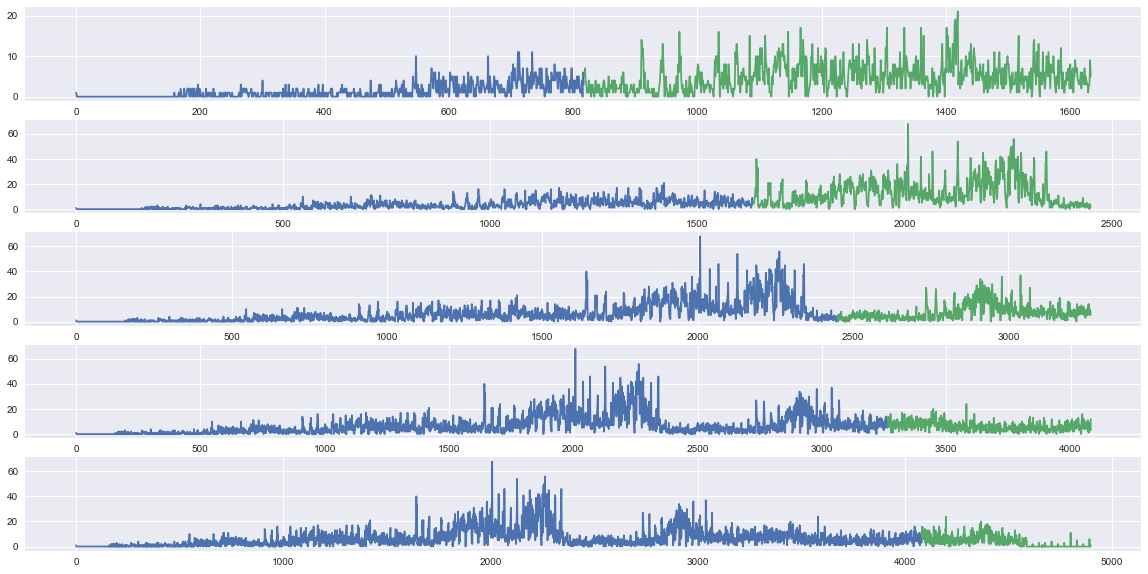

In [7]:
from sklearn.model_selection import TimeSeriesSplit

X = tmp_dt['Count'].values
splits = TimeSeriesSplit(n_splits=5)
plt.figure(1, figsize=(20,10))
index = 1
for train_index, test_index in splits.split(X):
    train = X[train_index]
    test = X[test_index]
    print('Observations: %d' % (len(train) + len(test)))
    print('Training Observations: %d' % (len(train)))
    print('Testing Observations: %d' % (len(test)))
    plt.subplot(510 + index)
    plt.plot(train)
    plt.plot([None for i in train] + [x for x in test])
    index += 1
plt.show()

Not so suitable for this case, as we are seeking
> Build a model to perform a 1-day forecast of the total number of daily occurrences.  

ie, a 1 day look forward forecast

# Walk Forward Method

1. **Minimum Number of Observations**. First, we must select the minimum number of observations required to train the model. This may be thought of as the window width if a sliding window is used (see next point).
2. **Sliding or Expanding Window**. Next, we need to decide whether the model will be trained on all data it has available or only on the most recent observations. This determines whether a sliding or expanding window will be used.


**How To Backtest Machine Learning Models for Time Series Forecasting**

https://machinelearningmastery.com/backtest-machine-learning-models-time-series-forecasting/

**11 Classical Time Series Forecasting Methods in Python (Cheat Sheet)**

https://machinelearningmastery.com/time-series-forecasting-methods-in-python-cheat-sheet/

In [8]:
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
# https://www.statsmodels.org/stable/examples/notebooks/generated/exponential_smoothing.html

def last_know_x(train):
    # return the moving average of the last x days 
    return train[len(train)-1:][0]

def moving_average_last_days(train, days=7):
    # return the moving average of the last x days 
    return np.mean(train[len(train)-days:])

def last_valid_over_x_days(train, days=7):
    # return the last valid values over x days, if none are found, return 0 
    result = [a for a in train[len(train)-days:] if a!=0]
    return result[len(result)-1] if result else 0
    
def simple_exp_smoothing_(train):
    fit1 = SimpleExpSmoothing(train).fit()
    return  fit1.forecast(1)
    
def holt_(train):
    fit2 = Holt(train).fit()
    return  fit2.forecast(1)
    
# def exponential_(train):
#     fit3 = Holt(train,exponential=True).fit()
#     return  fit3.forecast(1)
    
def additive_(train):
    fit4 = Holt(train,damped=True).fit(damping_slope=0.98)
    return  fit4.forecast(1)

# def multiplicative_(train):
#     fit5 = Holt(train,exponential=True,damped=True).fit()
#     return  fit5.forecast(1)
    

# Splitting the data

In [9]:
tmp_dt.pop('Date')
df = tmp_dt

In [10]:
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]

In [11]:
test_df

,Count
4408,3
4409,16
4410,14
4411,4
4412,3
...,...
4893,0
4894,0
4895,0
4896,0


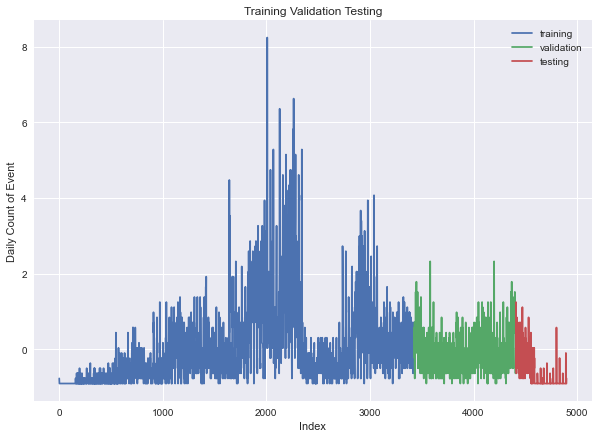

In [19]:
plt.figure(1, figsize=(10,7))
plt.plot(train_df.values, label='training')
plt.plot([None for i in train_df.values] + [x[0] for x in val_df.values], label='validation')
plt.plot([None for i in train_df.values] + [None for x in val_df.values] + [x[0] for x in test_df.values], label='testing')
plt.legend()

plt.title('Training Validation Testing')
plt.xlabel('Index')
plt.ylabel('Daily Count of Event')

plt.show()


# Normalising the data
While this is not essential here, it is require to ease the comparison between the naive methods vs keras methods

In [13]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

In [14]:
X = train_df.values.tolist()

initial = 1095 #3yrs
n_train = len(X)-initial
n_records = len(X)

target_list = []

last_know = []
moving_average3 = []
moving_average7 = []
moving_average21 = []
last_valid7 = []
last_valid21 = []
# s
simple_exp_smoothing_l = []
holt_l = []
additive_l = []

for i in range(n_train, n_records):
    train, target = X[0:i], X[i:i+1]
    
    # target
    target_list.append(target[0])
    
    # methods
    last_know.append(last_know_x(train)[0])
    moving_average3.append(moving_average_last_days(train, days=3))
    moving_average7.append(moving_average_last_days(train, days=7))
    moving_average21.append(moving_average_last_days(train, days=21))
    last_valid7.append(last_valid_over_x_days(train, days=7)[0])
    last_valid21.append(last_valid_over_x_days(train, days=21)[0])
    
    simple_exp_smoothing_l.append(simple_exp_smoothing_(train)[0])
    holt_l.append(holt_(train)[0])
    additive_l.append(additive_(train)[0])
    

C:\Users\MingHaoTeo\Anaconda3\envs\py38\lib\site-packages\statsmodels\tsa\holtwinters.py:743: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warn("Optimization failed to converge. Check mle_retvals.",
C:\Users\MingHaoTeo\Anaconda3\envs\py38\lib\site-packages\statsmodels\tsa\holtwinters.py:743: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warn("Optimization failed to converge. Check mle_retvals.",
C:\Users\MingHaoTeo\Anaconda3\envs\py38\lib\site-packages\statsmodels\tsa\holtwinters.py:743: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warn("Optimization failed to converge. Check mle_retvals.",
C:\Users\MingHaoTeo\Anaconda3\envs\py38\lib\site-packages\statsmodels\tsa\holtwinters.py:743: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warn("Optimization failed to converge. Check mle_retvals.",
C:\Users\MingHaoTeo\Anaconda3\envs\py38\lib\site-packages\statsmodels\tsa\holtwinters.py

In [15]:
from sklearn.metrics import mean_squared_error

print('last_know        :', mean_squared_error(target_list, last_know))
print('moving_average3  :', mean_squared_error(target_list, moving_average3))
print('moving_average7  :', mean_squared_error(target_list, moving_average7))
print('moving_average21 :', mean_squared_error(target_list, moving_average21))
print('last_valid7      :', mean_squared_error(target_list, last_valid7))
print('last_valid21     :', mean_squared_error(target_list, last_valid21))

print('simple_exp_smooth:', mean_squared_error(target_list, simple_exp_smoothing_l))
print('holt_l           :', mean_squared_error(target_list, holt_l))
print('additive_l       :', mean_squared_error(target_list, additive_l))



last_know        : 0.4267160266873866
moving_average3  : 0.4440576855528315
moving_average7  : 0.46139728439845434
moving_average21 : 0.462901698146998
last_valid7      : 0.4267160266873866
last_valid21     : 0.4267160266873866
simple_exp_smooth: 0.3862711812014235
holt_l           : 0.43988851851737665
additive_l       : 0.38628381839443976
